# Keras: как приручить карася

[__`Keras`__](https://keras.io/) - это библиотека для тех случаев, когда вам нужно быстро написать нейросеть без выкрутасов. И чтобы работала.

Если вы не хотите писать свои неповторимые архитектуры или угарать по нестандартным функциям потерь, keras позволит вам написать и обучить модель за 5 минут. Следите за руками.

In [1]:
import numpy as np
import keras, keras.layers as L

# model = keras.models.Sequential()
# model.add(L.InputLayer(input_shape=[64]))
# model.add(L.Dense(100, activation='relu'))
# model.add(L.Dense(10, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Using TensorFlow backend.


`1.` Создаём модель из __[`keras.models`](https://keras.io/models/about-keras-models/)__ – класс нейросети. 
   * __Sequential__ – модель в которой слои применяются ко входу последовательно.


`2.` Накидываем в модель слои из __[`keras.layers`](https://keras.io/layers/about-keras-layers/)__
   * В керасе есть набор стандартных слоёв для построения свёрточных и рекуррентных сетей: полносвязные слои, свёртки, pooling, lstm и пр. А если нет – можно [самому сделать](https://keras.io/layers/writing-your-own-keras-layers/#writing-your-own-keras-layers).

`3.` Описываем процесс обучения модели, __[`model.compile`](https://keras.io/getting-started/sequential-model-guide/#compilation)__
   * Указывается функция потерь и метод оптимизации. Есть ещё множество дополнительных параметров.

In [2]:
# что мы наворотили
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 7,510
Trainable params: 7,510
Non-trainable params: 0
_________________________________________________________________


После этого модель ведёт себя как любая модель из scikit-learn. fit, predict, всё как вы любите.

In [3]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)

model.fit(X, y, epochs=3)

y_pred = model.predict_classes(X)
y_proba = model.predict_proba(X)

from sklearn.metrics import accuracy_score
print("\nAccuracy = %.3f" % accuracy_score(y, y_pred))

Epoch 1/3
1797/1797 [==============================] - 2s 886us/step - loss: 3.3489 - acc: 0.5242
Epoch 2/3
1797/1797 [==============================] - 0s 59us/step - loss: 0.6755 - acc: 0.8358
Epoch 3/3
1797/1797 [==============================] - 0s 59us/step - loss: 0.2174 - acc: 0.9321

Accuracy = 0.950


А ещё у неё есть куча дополнительных возможностей. Например, сериализация обученной модели.
 * ```model.save("./saved_model.npz") ``` — сохранение модели вместе с весами
 * ```keras.models.load_model('./saved_model.npz`) ``` — загрузить обученную модель
 * ```model.train_on_batch ``` — сделать один шаг по градиенту на одном батче 
 * ```model.input_shape, model.output_shape ``` — размеры тензоров на входе и выходе сети 

### 1. Keras functional API
Вы также можете задавать более сложные модели на keras, строя граф из слоёв.

Разберём простой пример, в котором сеть содержит два параллельных полносвязных слоя, которые собираются вместе для вычисления выхода.

In [4]:
l_inp = L.Input(shape=[64], name='input_features')

l_dense1 = L.Dense(50, activation='relu')(l_inp)
l_dense2 = L.Dense(50, activation='elu')(l_inp)

l_combined = L.Concatenate()([l_dense1, l_dense2])

l_out = L.Dense(10, activation='softmax')(l_combined)

model = keras.models.Model(inputs=[l_inp], outputs=[l_out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 64)           0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 50)           3250        input_features[0][0]             
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 50)           3250        input_features[0][0]             
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 100)          0           dense_3[0][0]                    
                                                                 dense_4[0][0]                    
__________

Модели, созданные таким образом, можно использовать также как и sequential - у них есть fit, predict, save и прочие вкусности.

Более подробно можно почитать [тут](https://keras.io/getting-started/functional-api-guide/).

## 2. Keras + TensorFlow

Под капотом слои Keras написаны на TF (хотя вы можете выбрать другой фреймворк), и это даёт свои преимущества.

Предположим, вы хотите написать хитрую функцию потерь на tensorflow, но испольовать её вы хотите вместе с обычной моделью.

In [2]:
import tensorflow as tf

sess = keras.backend.get_session()
# sess = tf.InteractiveSession()

In [6]:
x = tf.placeholder('float32', [None, 64])

y_pred = model(x)

sess.run(y_pred, {x: X[:1]})

array([[1.3267314e-09, 6.8107788e-03, 3.2106522e-07, 2.7789396e-01,
        6.4907897e-01, 9.2410371e-03, 5.6484271e-02, 6.2480176e-08,
        4.9049914e-04, 1.5735512e-08]], dtype=float32)

__Грабли:__ в tensorflow может одновременно быть несколько сессий. Если вы используете keras, то все вычисления он будет делать в своей сессии : `keras.backend.get_session()`

__Почему это важно:__ когда вы говорите model.fit(...), веса нейронки обучаются в сессии кераса. Если у вас есть другие сессии (например, tf.InteractiveSession), в них никакого обучения не происходит, переменные даже не инициализированы.

Например, если сейчас позвать ```tf.InteractiveSession().run(y_pred, {x: X[:1]}))```, то tf ругнётся, что у него не инициализиованы веса модели.

__А можно проще?:__ если работаете в керасе, используйте `sess = keras.backend.get_session()`.

## 3. Surely You're Joking, Mr. Keras

Давайте разберём несколько архитектур на керасе. Попытайтесь понять, что с ними не так.

* __Задача:__ Предсказать цену дома в $mil
* __Вход:__ 39 признаков этого дома

In [7]:
model = keras.models.Sequential()
model.add(L.InputLayer([39]))
model.add(L.BatchNormalization())
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))
model.add(L.Dense(1))

model.compile(optimizer='sgd', loss='mean_squared_error')

Spoiler!

In [8]:
model = keras.models.Sequential()
model.add(L.InputLayer([39]))
model.add(L.BatchNormalization())                         
# ^ лучше нормализовать входы (не ошибка)

model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))
# ^ полносвязный слой без нелинейности (нейросеть не лучше линейной регрессии)
model.add(L.Dense(128, kernel_initializer=keras.initializers.zeros()))
# ^ так ещё и инициализируется нулями (эффект симметрии, нейроны будут одинаковыми)
model.add(L.Dense(1))

model.compile(optimizer='sgd', loss='mean_squared_error') 
# ^ попробовать relative mse, log-mse (не ошибка)

* __Задача:__ Распознать рукописную цифру (0-9)
* __Вход:__ картинка 28 x 28 пикселей (ч/б)

In [9]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Conv2D(filters=512, kernel_size=(3, 3)))
model.add(L.Activation('relu'))
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))
model.add(L.Dense(10))
model.add(L.Activation('softmax'))
model.add(L.Dropout(0.1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')

Spoiler!

In [10]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Conv2D(filters=512, kernel_size=(3, 3)))
# ^ многовато фильтров, вряд ли найдётся 512 значимо разных 3x3 карты
model.add(L.Activation('relu'))
model.add(L.MaxPool2D(pool_size=(2, 2)))
# ^ relu и max pool можно переставить местами, будет то же самое чуть быстрее (не ошибка)
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1)) # < хороший, годный дропаут
model.add(L.Dense(10))
model.add(L.Activation('softmax'))
model.add(L.Dropout(0.1))
# ^ не стоит dropout-ить вероятности на выходе, рискуете получить бесконечный лосс
model.compile(optimizer='rmsprop', loss='mean_squared_error')
# ^ обучать классификацию по квадратичной ошибке можно, но... это безбожно

* __Задача:__ тэгировать твиты: __Offensive, Illegal, Bot__. Твит может иметь несколько тэгов.
* __Вход:__ текст, каждое слово закодировано номером в словаре: от 1 до 9999

In [11]:
model = keras.models.Sequential()

model.add(L.InputLayer([None]))
model.add(L.Embedding(input_dim=10000, output_dim=128))
model.add(L.Conv1D(filters=64, kernel_size=3))
model.add(L.Activation('softmax'))
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(128))
model.add(L.Activation('softmax'))
model.add(L.Dense(3))
model.add(L.Activation('softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy')

Spoiler!

In [12]:
model = keras.models.Sequential()

model.add(L.InputLayer([None]))
model.add(L.Embedding(input_dim=10000, output_dim=128))
model.add(L.Conv1D(filters=64, kernel_size=3))
model.add(L.Activation('softmax'))
# ^ softmax плохо подходит для промежуточной нелинейности (почти все нейроны будут близки к 0)
model.add(L.GlobalMaxPool1D())
model.add(L.Dense(128))
model.add(L.Activation('softmax'))
# ^ и тут тоже
model.add(L.Dense(3))
model.add(L.Activation('softmax'))
# ^ должна быть сигмоида, поскольку твит может одновременно принадлежать нескольким классам
model.compile(optimizer='adam', loss='binary_crossentropy')

* __Задача:__ классификация одежды (10 классов)
* __Вход:__ картинка RGB 100 x 100 пикселей

In [25]:
model = keras.models.Sequential()
model.add(L.InputLayer([100, 100, 3]))

for filters in [32, 64, 128, 256]:
    print(filters)
    model.add(L.Conv2D(filters, kernel_size=(5, 5)))
    model.add(L.Conv2D(filters, kernel_size=(1, 1)))
    model.add(L.MaxPooling2D(pool_size=(3, 3)))
    model.add(L.Activation('relu'))
    model.add(L.BatchNormalization())

model.add(L.Flatten())

model.add(L.Dense(100, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_accuracy')

32
64
128
256


ValueError: Negative dimension size caused by subtracting 5 from 1 for 'conv2d_24/convolution' (op: 'Conv2D') with input shapes: [?,1,1,128], [5,5,128,256].

Spoiler!

In [ ]:
model = keras.models.Sequential()
model.add(L.InputLayer([100, 100, 3]))

for filters in [32, 64, 128, 256]:
    # ^ на четвёртой итерации вход станет меньше 5x5, свёртка "не влезет"
    model.add(L.Conv2D(filters, kernel_size=(5, 5)))
    model.add(L.Conv2D(filters, kernel_size=(1, 1)))
    # ^ свёртка 1x1 имела бы смысл, если бы перед ней была нелинейность
    model.add(L.MaxPooling2D(pool_size=(3, 3)))
    model.add(L.Activation('relu'))
    model.add(L.BatchNormalization())
    # ^ не ошибка, но рекоммендуют вставлять BatchNorm перед активацией

model.add(L.Flatten())

model.add(L.Dense(100, activation='relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_accuracy')
# accuracy имеет нулевую производную, поэтому оптимизировать лучше кроссэнтропию
# (sparse_categorical_crossentropy)

## 4. Обучим что-нибудь

Давайте пройдём процесс обучения нейронной сети от сбора данных до 

In [30]:
import numpy as np
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape([-1, 28, 28, 1])
X_test =  X_test.reshape([-1, 28, 28, 1])


print("Input shape:", X_train.shape)
print("Input range:", np.min(X_train), '-', np.max(X_train))

Input shape: (60000, 28, 28, 1)
Input range: 0 - 255


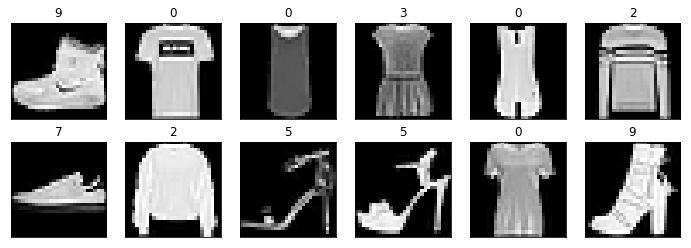

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 4))
for i in range(12):
    plt.subplot(2, 6, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(y_train[i])
    plt.xticks([]); plt.yticks([])

In [32]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_18 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(X_train, y_train, epochs=10, validation_data=[X_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 63us/step - loss: 14.4983 - sparse_categorical_accuracy: 0.1005 - val_loss: 14.5063 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/10
60000/60000 [==============================] - 4s 59us/step - loss: 14.5063 - sparse_categorical_accuracy: 0.1000 - val_loss: 14.5063 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/10
60000/60000 [==============================] - 3s 58us/step - loss: 14.5063 - sparse_categorical_accuracy: 0.1000 - val_loss: 14.5063 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/10
60000/60000 [==============================] - 3s 58us/step - loss: 14.5063 - sparse_categorical_accuracy: 0.1000 - val_loss: 14.5063 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/10
60000/60000 [==============================] - 3s 58us/step - loss: 14.5063 - sparse_categorical_accuracy: 0.1000 - val_loss: 14.5063 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/10
6000

__Что-то сломалось...__

Есть идеи, что не так?

_hint:_ данные неплохо бы привести в [0, 1]

In [35]:
model = keras.models.Sequential()
model.add(L.InputLayer([28, 28, 1]))

model.add(L.Conv2D(filters=512, kernel_size=(4, 4)))
model.add(L.Activation('relu'))
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))
model.add(L.Dense(10))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 18, 18, 1024)      124928    
_________________________________________________________________
activation_10 (Activation)   (None, 18, 18, 1024)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 9, 1024)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               8294500   
_________________________________________________________________
activation_11 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
__________

In [36]:
X_train = X_train / 255 
X_test = X_test / 255
model.fit(X_train, y_train, batch_size=512, epochs=100, validation_data=[X_test, y_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 5s 87us/step - loss: 5.1330 - sparse_categorical_accuracy: 0.1767 - val_loss: 1.7875 - val_sparse_categorical_accuracy: 0.1766
Epoch 2/100
60000/60000 [==============================] - 4s 73us/step - loss: 3.0674 - sparse_categorical_accuracy: 0.3984 - val_loss: 2.1993 - val_sparse_categorical_accuracy: 0.1548
Epoch 3/100
60000/60000 [==============================] - 4s 72us/step - loss: 3.7911 - sparse_categorical_accuracy: 0.2727 - val_loss: 2.1953 - val_sparse_categorical_accuracy: 0.1466
Epoch 4/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.2912 - sparse_categorical_accuracy: 0.1111 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.2904 - sparse_categorical_accuracy: 0.1060 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/100
60000/60

Epoch 88/100
60000/60000 [==============================] - 4s 73us/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 89/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.3025 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 90/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 91/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.3026 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 92/100
60000/60000 [==============================] - 4s 72us/step - loss: 2.3025 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 93/100
60000/60000 [==============================] - 4s 72

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras, tensorflow.keras.layers as L

augmenter = ImageDataGenerator(
    rotation_range=10, # degrees
    horizontal_flip=True,
)
augmenter.fit(X_train)

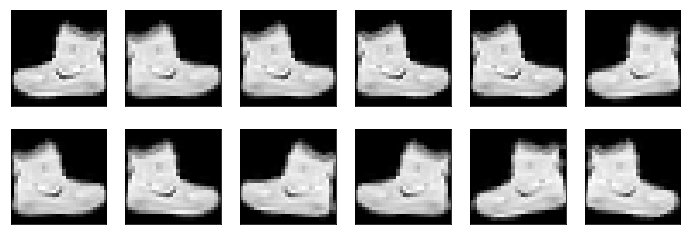

In [48]:
sample = augmenter.flow(np.repeat(X_train[:1], 12, axis=0), batch_size=12).next()

plt.figure(figsize=[12, 4])
for i in range(12):
    plt.subplot(2, 6, i + 1)
    plt.imshow(sample[i].reshape(28, 28), cmap='gray')
    plt.xticks([]); plt.yticks([])

In [49]:
model = tensorflow.keras.models.Sequential()

# <Your absolutely awesome convolutional network>
model.add(L.InputLayer([28, 28, 1]))
model.add(L.Conv2D(filters=512, kernel_size=(4, 4)))
model.add(L.Activation('relu'))
model.add(L.MaxPool2D(pool_size=(2, 2)))
model.add(L.Flatten())
model.add(L.Dense(100))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))
model.add(L.Dense(10))
model.add(L.Activation('relu'))
model.add(L.Dropout(0.1))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

model.fit_generator(augmenter.flow(X_train, y_train, batch_size=512),
                    epochs=100, validation_data=[X_test, y_test])

Epoch 1/100
118/118 [==============================] - 6s 48ms/step - loss: 5.6152 - sparse_categorical_accuracy: 0.1583 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 2/100
118/118 [==============================] - 5s 41ms/step - loss: 2.3049 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 3/100
118/118 [==============================] - 5s 42ms/step - loss: 2.3034 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 4/100
118/118 [==============================] - 5s 43ms/step - loss: 2.3042 - sparse_categorical_accuracy: 0.0998 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 5/100
118/118 [==============================] - 5s 42ms/step - loss: 2.3037 - sparse_categorical_accuracy: 0.1000 - val_loss: 2.3026 - val_sparse_categorical_accuracy: 0.1000
Epoch 6/100
118/118 [==============================] - 5s 43ms/step - loss: 2.3039 - spars

KeyboardInterrupt: 

### 6. Зоопарк моделей

У карася также есть свой маленький пруд с предобученными моделями: `keras.applications`. Как правило, это классификаторы изображений, обученные на выборке [ImageNet](http://image-net.org/) - около 1.3kk изображений. Давайте заценим.

In [62]:
import pickle
import keras, keras.layers as L
import keras.applications as zoo

classes = pickle.load(open('classes.pkl','rb'))
model = zoo.InceptionV3(include_top=True, weights='imagenet')

In [63]:
from skimage.transform import resize
def predict_top10(img):
    img = resize(img, (299, 299), mode='reflect')
    assert img.min() >= 0.0 and img.max() <= 1.0
    plt.imshow(img)
    plt.show()

    img_preprocessed = zoo.inception_v3.preprocess_input(img[None] * 255)
    probs = model.predict(img_preprocessed)[0]
    labels = probs.argsort()[-1:-10:-1]

    print('top-10 classes:')
    for l in labels:
        print('%.4f\t%s' % (probs.ravel()[l], classes[l].split(',')[0]))

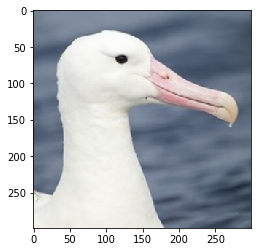

top-10 classes:
0.9290	albatross
0.0016	turnstile
0.0008	drake
0.0005	collie
0.0004	Shetland sheepdog
0.0004	nipple
0.0004	hammerhead
0.0004	cello
0.0004	goose


In [64]:
predict_top10(plt.imread('sample_images/albatross.jpg'))

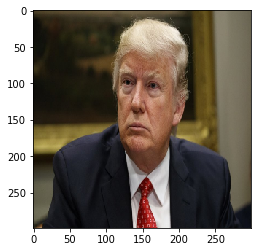

top-10 classes:
0.2540	suit
0.0773	groom
0.0300	Windsor tie
0.0115	wig
0.0092	oboe
0.0086	academic gown
0.0071	bow tie
0.0057	notebook
0.0050	mortarboard


In [65]:
# !wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg
predict_top10(plt.imread('img.jpg'))

__Внимание:__ InceptionV3 требует много памяти для работы. Если ваш ПК начинает зависать,
* закройте ~~ютюб и сериальчики~~ все программы кроме jupyter и браузера с одной вкладкой
* если не помогло, загрузите эту тетрадку в [google colab](https://colab.research.google.com/) и работайте там

Ещё можно попробовать заменить `zoo.InceptionV3` на `zoo.MobileNet`. Вам также придётся исправить предобработку картинки.

## 7. (Optional) Немного RNN-ок

Карась великодушно позволяет вам обучать рекуррентные сети с таким же интерфейсом, что и свёрточные. Рекуррентный слой применяется сразу ко всей последовательности входов.

Для примера решим задачу классификации отзывов на фильмы с IMDB: дан текст отзыва, разбитый на слова; нужно предсказать оценку: __"1"__  - положительный , __"0"__ - отрицательный.

In [2]:
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

Каждое слово в данных закодировано уникальным номером в словаре из 5000 наиболее частых слов.

In [3]:
voc = imdb.get_word_index()
print([voc.get(word, 0) for word in "i absolutely loved the movie for its honesty".split()])

[10, 424, 444, 1, 17, 15, 91, 4371]


Особенность работы с текстами в том, что все примеры имеют разную длину. Чтобы собрать их в одну матрицу, давайте выберем некоторую целевую длину.
Дополним слишком короткие последовательности до неё нулями и обрежем слишком длинные.

In [4]:
from keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(x_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)
print(x_train.shape, x_test.shape)

(25000, 100) (25000, 100)


Последовательности внутри keras представлены в формате 3-мерных тензоров: __`[batch_size, length, channels]`__. Например, последовательность 100-мерных векторов word2vec для двух предложений до 12 слов каждое будут иметь форму `[2, 12, 100]`.

In [5]:
model = keras.models.Sequential()
model.add(L.InputLayer(input_shape=[None]))

model.add(L.Embedding(5000, 128))

model.add(L.LSTM(64, return_sequences=True, recurrent_dropout=0.2))

model.add(L.GlobalMaxPool1D())

model.add(L.Dense(2, activation='softmax'))

model.compile('adam', loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         640000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 130       
Total params: 689,538
Trainable params: 689,538
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(x_train, y_train, epochs=3, batch_size=256)

Epoch 1/3
25000/25000 [==============================] - 10s 404us/step - loss: 0.5580 - sparse_categorical_accuracy: 0.7226
Epoch 2/3
25000/25000 [==============================] - 8s 326us/step - loss: 0.3434 - sparse_categorical_accuracy: 0.8556
Epoch 3/3
25000/25000 [==============================] - 8s 326us/step - loss: 0.2889 - sparse_categorical_accuracy: 0.8839


In [72]:
from sklearn.metrics import accuracy_score, roc_auc_score
y_test_probs = model.predict_proba(x_test, verbose=True)[:, 1]
print("Test scores:")
print("Accuracy:", accuracy_score(y_test, y_test_probs > 0.5))
print("ROC AUC:", roc_auc_score(y_test, y_test_probs))

25000/25000 [==============================] - 33s 1ms/step
Test scores:
Accuracy: 0.8434
ROC AUC: 0.9225919904000001


In [73]:
example = "i really loved that movie . the plot was thrilling , the visual effects were just astonishing ."
xi = np.array([[voc.get(word, 0) for word in example.lower().split()]])
print(xi)
print("P(positive | x) = %.3f" % model.predict_proba(xi)[:, 1])

[[  10   63  444   12   17    0    1  111   13 3014    0    1 1111  299
    68   40 5146    0]]
P(positive | x) = 0.711
